In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, cophenet
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
df = pd.read_csv('cluster_data-3.csv')
df.head()

,rn,activity,tBodyAcc.mean.X,tBodyAcc.mean.Y,tBodyAcc.mean.Z,tBodyAcc.std.X,tBodyAcc.std.Y,tBodyAcc.std.Z,tBodyAcc.mad.X,tBodyAcc.mad.Y,tBodyAcc.mad.Z,tBodyAcc.max.X,tBodyAcc.max.Y,tBodyAcc.max.Z,tBodyAcc.min.X,tBodyAcc.min.Y,tBodyAcc.min.Z,tBodyAcc.sma,tBodyAcc.energy.X,tBodyAcc.energy.Y,tBodyAcc.energy.Z,tBodyAcc.iqr.X,tBodyAcc.iqr.Y,tBodyAcc.iqr.Z,tBodyAcc.entropy.X,tBodyAcc.entropy.Y,tBodyAcc.entropy.Z,tBodyAcc.arCoeff.X.1,tBodyAcc.arCoeff.X.2,tBodyAcc.arCoeff.X.3,tBodyAcc.arCoeff.X.4,tBodyAcc.arCoeff.Y.1,tBodyAcc.arCoeff.Y.2,tBodyAcc.arCoeff.Y.3,tBodyAcc.arCoeff.Y.4,tBodyAcc.arCoeff.Z.1,tBodyAcc.arCoeff.Z.2,tBodyAcc.arCoeff.Z.3,tBodyAcc.arCoeff.Z.4,tBodyAcc.correlation.X.Y,...,fBodyBodyAccJerkMag.energy,fBodyBodyAccJerkMag.iqr,fBodyBodyAccJerkMag.entropy,fBodyBodyAccJerkMag.maxInds,fBodyBodyAccJerkMag.meanFreq,fBodyBodyAccJerkMag.skewness,fBodyBodyAccJerkMag.kurtosis,fBodyBodyGyroMag.mean,fBodyBodyGyroMag.std,fBodyBodyGyroMag.mad,fBodyBodyGyroMag.max,fBodyBodyGyroMag.min,fBodyBodyGyroMag.sma,fBodyBodyGyroMag.energy,fBodyBodyGyroMag.iqr,fBodyBodyGyroMag.entropy,fBodyBodyGyroMag.maxInds,fBodyBodyGyroMag.meanFreq,fBodyBodyGyroMag.skewness,fBodyBodyGyroMag.kurtosis,fBodyBodyGyroJerkMag.mean,fBodyBodyGyroJerkMag.std,fBodyBodyGyroJerkMag.mad,fBodyBodyGyroJerkMag.max,fBodyBodyGyroJerkMag.min,fBodyBodyGyroJerkMag.sma,fBodyBodyGyroJerkMag.energy,fBodyBodyGyroJerkMag.iqr,fBodyBodyGyroJerkMag.entropy,fBodyBodyGyroJerkMag.maxInds,fBodyBodyGyroJerkMag.meanFreq,fBodyBodyGyroJerkMag.skewness,fBodyBodyGyroJerkMag.kurtosis,angle.tBodyAccMean.gravity,angle.tBodyAccJerkMean.gravityMean,angle.tBodyGyroMean.gravityMean,angle.tBodyGyroJerkMean.gravityMean,angle.X.gravityMean,angle.Y.gravityMean,angle.Z.gravityMean
0,7,STANDING,0.279,-0.0196,-0.1100,-0.997,-0.967,-0.983,-0.997,-0.966,-0.983,-0.941,-0.566,-0.817,0.851,0.674,0.834,-0.987,-1.0,-1.000,-1.000,-0.997,-0.972,-0.983,-0.637,-0.5150,-0.537,0.360,-0.233,0.2260,0.0695,0.0643,-0.0764,0.138,-0.0368,0.231,-0.1150,0.3190,-0.48800,-0.0959,...,-1.0,-0.991,-1.0,-0.905,0.290,-0.669,-0.933,-0.988,-0.985,-0.984,-0.985,-0.995,-0.988,-1.000,-0.989,-0.736,-1.000,-0.2570,-0.32200,-0.6580,-0.996,-0.995,-0.994,-0.994,-0.997,-0.996,-1.0,-0.994,-0.956,-1.000,0.146,-0.217,-0.5640,-0.2130,-0.2310,0.0146,-0.190,-0.852,0.182,-0.0430
1,11,STANDING,0.277,-0.0127,-0.1030,-0.995,-0.973,-0.985,-0.996,-0.974,-0.985,-0.940,-0.555,-0.816,0.845,0.685,0.838,-0.988,-1.0,-1.000,-1.000,-0.996,-0.980,-0.983,-0.629,-0.3970,-0.424,0.346,-0.174,0.1780,0.1690,-0.0202,0.1360,-0.114,0.2430,0.301,-0.0764,0.0820,0.15300,0.0085,...,-1.0,-0.984,-1.0,-1.000,0.502,-0.517,-0.786,-0.983,-0.981,-0.982,-0.979,-0.987,-0.983,-1.000,-0.981,-0.641,-1.000,-0.0472,0.00787,-0.2840,-0.991,-0.989,-0.991,-0.987,-0.980,-0.991,-1.0,-0.992,-0.923,-1.000,0.121,0.349,0.0577,0.0807,0.5960,-0.4760,0.116,-0.852,0.188,-0.0347
2,14,STANDING,0.277,-0.0147,-0.1070,-0.999,-0.991,-0.993,-0.999,-0.991,-0.992,-0.943,-0.569,-0.823,0.852,0.693,0.846,-0.997,-1.0,-1.000,-1.000,-0.998,-0.993,-0.990,-0.888,-0.5540,-0.551,0.412,-0.128,0.2650,0.0677,0.2890,-0.2410,0.315,-0.1520,0.181,0.0504,-0.0398,-0.00999,0.0436,...,-1.0,-0.994,-1.0,-0.905,0.530,-0.606,-0.869,-0.999,-0.998,-0.998,-0.999,-0.998,-0.999,-1.000,-0.996,-1.000,-0.949,0.3250,-0.75900,-0.9420,-0.999,-0.999,-0.999,-0.999,-0.995,-0.999,-1.0,-0.999,-1.000,-0.968,0.740,-0.564,-0.7660,0.1060,-0.0903,-0.1320,0.499,-0.850,0.189,-0.0351
3,15,STANDING,0.298,0.0271,-0.0617,-0.989,-0.817,-0.902,-0.989,-0.794,-0.888,-0.926,-0.448,-0.731,0.849,0.681,0.838,-0.904,-1.0,-0.989,-0.991,-0.989,-0.770,-0.869,-0.163,0.0546,0.073,0.158,-0.160,0.1900,-0.3220,-0.3150,0.2790,-0.307,0.3430,-0.083,0.0273,-0.0465,-0.08650,0.8220,...,-1.0,-0.984,-1.0,-1.000,0.169,-0.522,-0.818,-0.911,-0.884,-0.898,-0.880,-0.847,-0.911,-0.993,-0.956,-0.387,-1.000,-0.1730,0.07620,-0.3040,-0.990,-0.989,-0.990,-0.987,-0.999,-0.990,-1.0,-0.992,-0.923,-1.000,0.131,0.208,-0.0681,0.0623,-0.0587,0.0312,-0.269,-0.731,0.283,0.0364
4,20,STANDING,0.276,-0.0170,-0.1110,-0

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
std  = StandardScaler()
cluster_df = df.drop("activity", axis=1)

In [7]:
std_cluster_df = pd.DataFrame(std.fit_transform(cluster_df), columns=cluster_df.columns)
std_cluster_df.head()

,rn,tBodyAcc.mean.X,tBodyAcc.mean.Y,tBodyAcc.mean.Z,tBodyAcc.std.X,tBodyAcc.std.Y,tBodyAcc.std.Z,tBodyAcc.mad.X,tBodyAcc.mad.Y,tBodyAcc.mad.Z,tBodyAcc.max.X,tBodyAcc.max.Y,tBodyAcc.max.Z,tBodyAcc.min.X,tBodyAcc.min.Y,tBodyAcc.min.Z,tBodyAcc.sma,tBodyAcc.energy.X,tBodyAcc.energy.Y,tBodyAcc.energy.Z,tBodyAcc.iqr.X,tBodyAcc.iqr.Y,tBodyAcc.iqr.Z,tBodyAcc.entropy.X,tBodyAcc.entropy.Y,tBodyAcc.entropy.Z,tBodyAcc.arCoeff.X.1,tBodyAcc.arCoeff.X.2,tBodyAcc.arCoeff.X.3,tBodyAcc.arCoeff.X.4,tBodyAcc.arCoeff.Y.1,tBodyAcc.arCoeff.Y.2,tBodyAcc.arCoeff.Y.3,tBodyAcc.arCoeff.Y.4,tBodyAcc.arCoeff.Z.1,tBodyAcc.arCoeff.Z.2,tBodyAcc.arCoeff.Z.3,tBodyAcc.arCoeff.Z.4,tBodyAcc.correlation.X.Y,tBodyAcc.correlation.X.Z,...,fBodyBodyAccJerkMag.energy,fBodyBodyAccJerkMag.iqr,fBodyBodyAccJerkMag.entropy,fBodyBodyAccJerkMag.maxInds,fBodyBodyAccJerkMag.meanFreq,fBodyBodyAccJerkMag.skewness,fBodyBodyAccJerkMag.kurtosis,fBodyBodyGyroMag.mean,fBodyBodyGyroMag.std,fBodyBodyGyroMag.mad,fBodyBodyGyroMag.max,fBodyBodyGyroMag.min,fBodyBodyGyroMag.sma,fBodyBodyGyroMag.energy,fBodyBodyGyroMag.iqr,fBodyBodyGyroMag.entropy,fBodyBodyGyroMag.maxInds,fBodyBodyGyroMag.meanFreq,fBodyBodyGyroMag.skewness,fBodyBodyGyroMag.kurtosis,fBodyBodyGyroJerkMag.mean,fBodyBodyGyroJerkMag.std,fBodyBodyGyroJerkMag.mad,fBodyBodyGyroJerkMag.max,fBodyBodyGyroJerkMag.min,fBodyBodyGyroJerkMag.sma,fBodyBodyGyroJerkMag.energy,fBodyBodyGyroJerkMag.iqr,fBodyBodyGyroJerkMag.entropy,fBodyBodyGyroJerkMag.maxInds,fBodyBodyGyroJerkMag.meanFreq,fBodyBodyGyroJerkMag.skewness,fBodyBodyGyroJerkMag.kurtosis,angle.tBodyAccMean.gravity,angle.tBodyAccJerkMean.gravityMean,angle.tBodyGyroMean.gravityMean,angle.tBodyGyroJerkMean.gravityMean,angle.X.gravityMean,angle.Y.gravityMean,angle.Z.gravityMean
0,-1.729350,0.070090,-0.051303,-0.014321,-0.884871,-0.918609,-0.922544,-0.877109,-0.915758,-0.929283,-0.877531,-0.934254,-0.902866,0.912050,0.840898,0.809898,-0.944990,-0.699994,-0.754026,-0.706961,-0.854124,-0.899465,-0.927370,-1.147949,-0.900065,-1.034948,1.557323,-1.365810,1.053172,-0.222504,0.385189,-0.528896,-0.062228,-0.103690,0.807588,-0.706577,1.206910,-1.758075,0.053990,0.201169,...,-0.687435,-0.857648,-0.991778,-0.153028,0.459925,-1.008539,-0.928673,-0.895016,-0.914185,-0.914879,-0.885220,-0.644773,-0.895016,-0.644644,-0.859282,-1.101836,-0.699415,-0.754693,-0.182344,-0.258447,-0.800844,-0.777334,-0.782306,-0.756387,-0.655572,-0.800844,-0.467058,-0.790661,-1.091315,-0.714721,0.071576,0.263638,0.179717,-0.663934,-0.535708,-0.023772,-0.365489,-0.697128,0.391822,0.027291
1,-1.728005,0.038634,0.110734,0.110213,-0.880316,-0.930571,-0.927550,-0.874688,-0.932246,-0.934348,-0.875680,-0.895324,-0.899297,0.895291,0.873297,0.823683,-0.947157,-0.699994,-0.754026,-0.706961,-0.851339,-0.921154,-0.927370,-1.130787,-0.627865,-0.727467,1.512095,-1.131966,0.862030,0.203159,0.053565,0.469474,-1.275227,1.164334,1.056217,-0.528021,0.206673,1.035771,0.345505,-0.478036,...,-0.687435,-0.838620,-0.991778,-0.637897,1.294132,-0.593793,-0.516966,-0.879553,-0.901379,-0.908831,-0.864053,-0.596896,-0.879553,-0.644644,-0.833269,-0.943311,-0.699415,-0.002040,0.839981,0.912715,-0.782157,-0.754056,-0.771549,-0.727185,-0.565472,-0.782157,-0.467058,-0.783447,-1.038279,-0.714721,-0.032484,2.043967,2.196519,0.220164,1.306538,-0.823407,0.258032,-0.697128,0.411099,0.058742
2,-1.726997,0.038634,0.063767,0.039051,-0.889426,-0.966460,-0.947578,-0.881950,-0.967282,-0.952075,-0.881234,-0.944872,-0.924281,0.914843,0.896860,0.851254,-0.966660,-0.699994,-0.754026,-0.706961,-0.856910,-0.956400,-0.946378,-1.686413,-0.990030,-1.073043,1.725315,-0.949647,1.208475,-0.230204,1.267036,-1.302586,0.789759,-0.625764,0.629996,0.058531,-0.307373,0.325367,0.443515,0.176470,...,-0.687435,-0.865803,-0.991778,-0.153028,1.404310,-0.836638,-0.749426,-0.929033,-0.955804,-0.957218,-0.934609,-0.662727,-0.929033,-0.644644,-0.882043,-1.542368,-0.382266,1.333221,-1.536683,-1.147777,-0.812056,-0.792852,-0.800235,-0.777246,-0.644972,-0.812056,-0.467058,-0.808694,-1.162029,-0.484701

In [8]:
std_cluster_df.shape

(3609, 562)

In [9]:
pca = PCA(n_components=562)
pca = pca.fit(std_cluster_df)

In [42]:
exp_var = pd.DataFrame({ "Feature":pca.feature_names_in_,"ExpVar":pca.explained_variance_, "Index":np.arange(len(pca.feature_names_in_))}).sort_values(by='ExpVar', ascending=False)

In [43]:
exp_var['percent'] = exp_var['ExpVar'].cumsum(axis=0)/exp_var['ExpVar'].sum()

In [44]:
exp_var[exp_var['percent']<=0.9005]

,Feature,ExpVar,Index,percent
0,rn,285.164770,0,0.507270
1,tBodyAcc.mean.X,36.388990,1,0.572001
2,tBodyAcc.mean.Y,15.490287,2,0.599556
3,tBodyAcc.mean.Z,13.284234,3,0.623187
4,tBodyAcc.std.X,10.626283,4,0.642090
...,...,...,...,...
59,tGravityAcc.energy.Z,1.054076,59,0.893299
60,tGravityAcc.iqr.X,1.026288,60,0.895124
61,tGravityAcc.iqr.Y,1.019675,61,0.896938
62,tGravityAcc.iqr.Z,1.002892,62,0.898722


In [29]:
print("64 variables are required for achieving 90% of explained variance")

64 variables are required for achieving 90% of explained variance


In [31]:
corr_df = std_cluster_df.corr()

In [32]:
corr_df[(corr_df>=0.8).any(axis=1)]

,rn,tBodyAcc.mean.X,tBodyAcc.mean.Y,tBodyAcc.mean.Z,tBodyAcc.std.X,tBodyAcc.std.Y,tBodyAcc.std.Z,tBodyAcc.mad.X,tBodyAcc.mad.Y,tBodyAcc.mad.Z,tBodyAcc.max.X,tBodyAcc.max.Y,tBodyAcc.max.Z,tBodyAcc.min.X,tBodyAcc.min.Y,tBodyAcc.min.Z,tBodyAcc.sma,tBodyAcc.energy.X,tBodyAcc.energy.Y,tBodyAcc.energy.Z,tBodyAcc.iqr.X,tBodyAcc.iqr.Y,tBodyAcc.iqr.Z,tBodyAcc.entropy.X,tBodyAcc.entropy.Y,tBodyAcc.entropy.Z,tBodyAcc.arCoeff.X.1,tBodyAcc.arCoeff.X.2,tBodyAcc.arCoeff.X.3,tBodyAcc.arCoeff.X.4,tBodyAcc.arCoeff.Y.1,tBodyAcc.arCoeff.Y.2,tBodyAcc.arCoeff.Y.3,tBodyAcc.arCoeff.Y.4,tBodyAcc.arCoeff.Z.1,tBodyAcc.arCoeff.Z.2,tBodyAcc.arCoeff.Z.3,tBodyAcc.arCoeff.Z.4,tBodyAcc.correlation.X.Y,tBodyAcc.correlation.X.Z,...,fBodyBodyAccJerkMag.energy,fBodyBodyAccJerkMag.iqr,fBodyBodyAccJerkMag.entropy,fBodyBodyAccJerkMag.maxInds,fBodyBodyAccJerkMag.meanFreq,fBodyBodyAccJerkMag.skewness,fBodyBodyAccJerkMag.kurtosis,fBodyBodyGyroMag.mean,fBodyBodyGyroMag.std,fBodyBodyGyroMag.mad,fBodyBodyGyroMag.max,fBodyBodyGyroMag.min,fBodyBodyGyroMag.sma,fBodyBodyGyroMag.energy,fBodyBodyGyroMag.iqr,fBodyBodyGyroMag.entropy,fBodyBodyGyroMag.maxInds,fBodyBodyGyroMag.meanFreq,fBodyBodyGyroMag.skewness,fBodyBodyGyroMag.kurtosis,fBodyBodyGyroJerkMag.mean,fBodyBodyGyroJerkMag.std,fBodyBodyGyroJerkMag.mad,fBodyBodyGyroJerkMag.max,fBodyBodyGyroJerkMag.min,fBodyBodyGyroJerkMag.sma,fBodyBodyGyroJerkMag.energy,fBodyBodyGyroJerkMag.iqr,fBodyBodyGyroJerkMag.entropy,fBodyBodyGyroJerkMag.maxInds,fBodyBodyGyroJerkMag.meanFreq,fBodyBodyGyroJerkMag.skewness,fBodyBodyGyroJerkMag.kurtosis,angle.tBodyAccMean.gravity,angle.tBodyAccJerkMean.gravityMean,angle.tBodyGyroMean.gravityMean,angle.tBodyGyroJerkMean.gravityMean,angle.X.gravityMean,angle.Y.gravityMean,angle.Z.gravityMean
rn,1.000000,-0.004802,-0.008770,-0.009819,-0.028609,-0.035308,-0.029763,-0.030839,-0.033197,-0.033279,-0.009312,-0.030341,-0.021714,0.039839,0.044083,0.014185,-0.033928,-0.053350,-0.052128,-0.049640,-0.040603,-0.025774,-0.044095,-0.004265,-0.021314,0.002137,-0.004513,0.003422,0.016846,-0.019738,0.005537,-0.012467,-0.022954,0.057992,0.017685,-0.006007,-0.026560,0.062603,0.012123,-0.039719,...,-0.044633,-0.037723,-0.016187,-0.011682,-0.032831,0.044542,0.047147,-0.048963,-0.032111,-0.037847,-0.032642,-0.071953,-0.048963,-0.055746,-0.046764,-0.008004,0.009422,-0.039650,-0.009410,-0.015689,-0.050026,-0.044801,-0.049355,-0.038397,-0.036679,-0.050026,-0.060970,-0.055763,-0.014425,-0.008201,0.001352,0.018748,0.017398,-0.003656,0.009594,0.026851,0.007878,0.011733,-0.000399,-0.030607
tBodyAcc.mean.X,-0.004802,1.000000,0.216780,-0.302976,0.026776,-0.000438,-0.018657,0.033594,-0.001558,-0.021714,0.056893,0.025259,-0.052098,0.039521,0.010761,-0.034230,-0.011840,0.049030,-0.027067,-0.056379,0.054101,-0.008566,-0.028507,0.177481,0.035838,-0.097648,0.027248,-0.012164,-0.009825,0.049893,0.027578,0.004777,-0.022859,0.038613,0.021049,0.031487,-0.023348,-0.003240,0.035906,0.089248,...,0.049951,0.029323,0.007409,0.021868,0.042157,-0.014592,-0.009174,0.021581,-0.005266,0.004987,-0.018869,0.006984,0.021581,0.015248,0.029679,-0.000100,0.044335,0.060448,-0.059596,-0.054006,0.040623,0.037583,0.036513,0.041071,0.044561,0.040623,0.049302,0.035842,0.004981,0.015450,0.024893,-0.003043,-0.003782,-0.567714,0.017247,0.038627,0.035722,-0.027148,0.033745,0.025944
tBodyAcc.mean.Y,-0.008770,0.216780,1.000000,-0.104570,-0.053585,-0.042304,-0.049965,-0.052898,-0.040302,-0.051028,-0.040163,0.091108,-0.065630,0.072797,0.137241,0.035448,-0.050631,-0.043134,-0.053727,-0.075646,-0.053242,-0.038829,-0.056638,0.004426,0.200208,-0.027156,0.037025,-0.049908,0.040720,-0.041671,0.020650,-0.036953,0.022016,-0.007402,0.009620,-0.011776,-0.004233,-0.002991,0.013230,-0.002365,...,-0.040662,-0.053510,-0.054734,-0.000493,-0.012748,-0.012019,-0.012539,-0.054022,-0.054772,-0.059800,-0.048723,-0.035859,-0.054022,-0.049470,-0.056742,-0.045186,-0.010827,-0.011358,0.017102,0.012889,-0.040876,-0.038960,-0.039239,-0.038198,-0.037767,-0.040876,-0.021256,-0.042987,-0.043735,0.007031

In [36]:
high_corr_pairs = []
for i in range(len(corr_df.columns)):
    for j in range(i+1, len(corr_df.columns)):  # Avoid duplicates
        if abs(corr_df.iloc[i, j]) >= 0.8:  # Absolute value for positive/negative correlations
            high_corr_pairs.append((corr_df.index[i], corr_df.columns[j], corr_df.iloc[i, j]))

# Convert to DataFrame for better visualization
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df.head()

,Feature 1,Feature 2,Correlation
0,tBodyAcc.std.X,tBodyAcc.std.Y,0.924174
1,tBodyAcc.std.X,tBodyAcc.std.Z,0.867681
2,tBodyAcc.std.X,tBodyAcc.mad.X,0.998675
3,tBodyAcc.std.X,tBodyAcc.mad.Y,0.917302
4,tBodyAcc.std.X,tBodyAcc.mad.Z,0.862121


In [37]:
high_corr_df.shape

(22912, 3)

In [49]:
#Top 5 eigenvectors
pca.components_[0:5,0:5]

array([[-0.00230078,  0.00151581, -0.00281301, -0.00214038,  0.05644067],
       [-0.00814789,  0.01978946, -0.0033616 , -0.00722248, -0.01098062],
       [ 0.00579233,  0.02805623, -0.00789873, -0.02197337,  0.02143985],
       [-0.00153351, -0.01588924, -0.00475115,  0.00683051,  0.0415385 ],
       [ 0.01143407, -0.00407673, -0.01058876, -0.00396254, -0.00530695]])

In [55]:
reduced_pca = PCA(n_components=5)
reduced_pca = reduced_pca.fit(std_cluster_df)

In [59]:
red_pca_df = reduced_pca.transform(std_cluster_df)

In [60]:
red_pca_df.shape

(3609, 5)

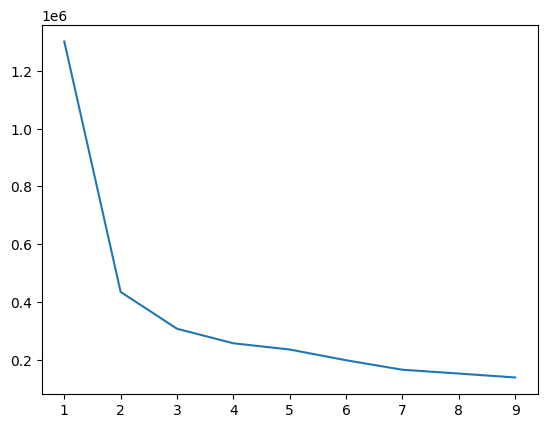

In [62]:
import matplotlib.pyplot as plt
wcss = []
for k in range(1, 10):
    kmeans_mod = KMeans(n_clusters=k)
    kmeans_mod = kmeans_mod.fit(red_pca_df)
    wcss.append(kmeans_mod.inertia_)
plt.plot(range(1,10), wcss)

In [63]:
#2 Clusters can be observed using elbow method.

In [64]:
df.activity.value_counts()

activity
LAYING                681
STANDING              668
SITTING               623
WALKING               603
WALKING_UPSTAIRS      541
WALKING_DOWNSTAIRS    493
Name: count, dtype: int64

In [65]:
#Based on the activity, one can say, the cluster predicts if the person is moving or stationary.

In [66]:
def calculate_wcss_per_cluster(X, kmeans):
    # Get cluster assignments and centroids
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    # Initialize dictionary to store WCSS for each cluster
    wcss_per_cluster = {}
    
    # Calculate WCSS for each cluster
    for i in range(kmeans.n_clusters):
        # Get points in this cluster
        cluster_points = X[labels == i]
        
        if len(cluster_points) > 0:  # Check if cluster is not empty
            # Get centroid for this cluster
            centroid = centroids[i]
            
            # Calculate squared distances from points to centroid
            squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
            
            # Sum up the squared distances
            wcss_cluster = np.sum(squared_distances)
            
            # Store in dictionary
            wcss_per_cluster[i] = wcss_cluster
    
    return wcss_per_cluster

In [68]:
clus_5 = KMeans(n_clusters=5)
clus_5 = clus_5.fit(red_pca_df)

In [69]:
calculate_wcss_per_cluster(red_pca_df, clus_5)

{0: 41487.96428264973,
 1: 41651.12045148287,
 2: 35199.76500666471,
 3: 43688.651798575025,
 4: 49525.58469899913}

In [70]:
#WCSS for each cluster.

In [71]:
from scipy.cluster.hierarchy import linkage

<Figure size 2000x2000 with 0 Axes>

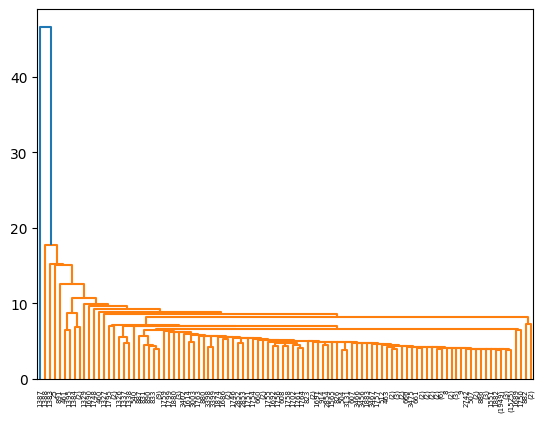

<Figure size 2000x2000 with 0 Axes>

In [82]:
single_link_mat = linkage(red_pca_df,method='single', metric='euclidean')
dendo = dendrogram(single_link_mat, truncate_mode='lastp', p=100)
plt.figure(figsize=(20,20))

<Figure size 2000x2000 with 0 Axes>

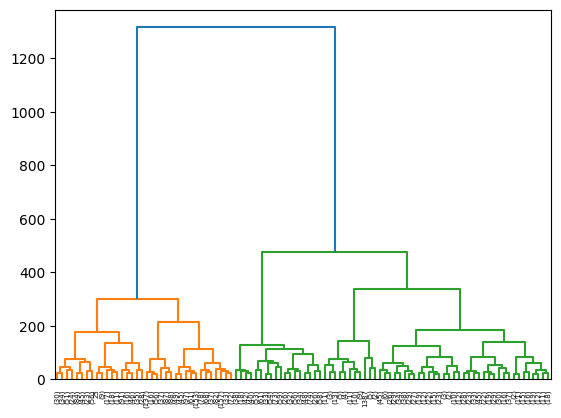

<Figure size 2000x2000 with 0 Axes>

In [83]:
ward_link_mat = linkage(red_pca_df,method='ward', metric='euclidean')
dendo = dendrogram(ward_link_mat, truncate_mode='lastp', p=100)
plt.figure(figsize=(20,20))

<Figure size 2000x2000 with 0 Axes>

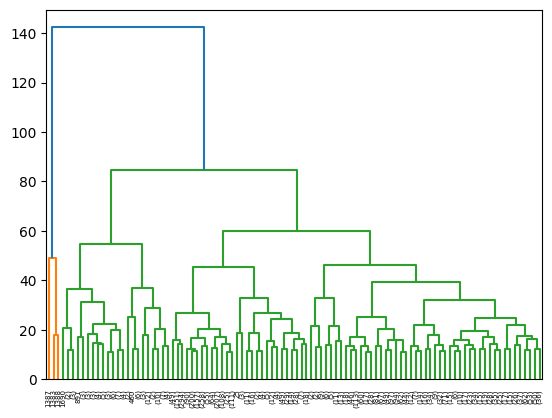

<Figure size 2000x2000 with 0 Axes>

In [85]:
complete_link_mat = linkage(red_pca_df,method='complete', metric='euclidean')
dendo = dendrogram(complete_link_mat, truncate_mode='lastp', p=100)
plt.figure(figsize=(20,20))

<Figure size 2000x2000 with 0 Axes>

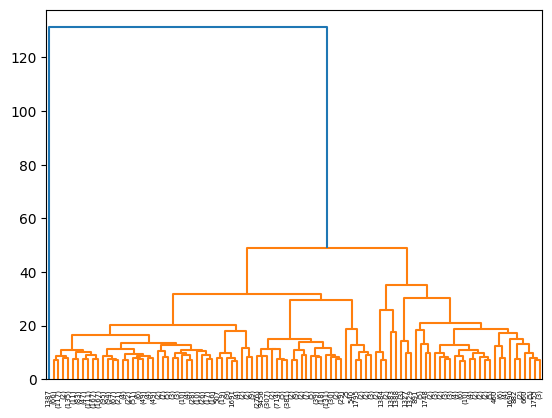

<Figure size 2000x2000 with 0 Axes>

In [90]:
avg_link_mat = linkage(red_pca_df,method='average', metric='euclidean')
dendo = dendrogram(avg_link_mat, truncate_mode='lastp', p=100)
plt.figure(figsize=(20,20))


In [93]:
from sklearn.metrics import euclidean_distances
eucli_dist = euclidean_distances(red_pca_df)
eucli_dist.shape

(3609, 3609)

In [96]:
# calculate the euclidean distance between the observations 
for mat in [avg_link_mat, ward_link_mat, single_link_mat, complete_link_mat]:
    eucli_dist = euclidean_distances(red_pca_df)

    # the above code will return the matrix of 5192x5192
    # consider only the array of upper triangular matrix
    # k=1 considers the upper triangular values without the diagonal elements
    dist_array = eucli_dist[np.triu_indices(3609, k = 1)]
    
    # pass the linkage matrix and actual distance
    # 1st output of the cophenet() is the correlation coefficient
    coeff, cophenet_dist = cophenet(mat, dist_array)
    
    # print the cophenetic correlation coefficient
    print(coeff)

0.8708086164354443
0.7749507826369708
0.7601191303605379
0.8559086653644944


In [107]:
#Section C
from sklearn.model_selection import train_test_split

In [108]:
from sklearn.metrics import accuracy_score
def provide_model_perf_report(model, x_, y_):
    x_train, x_test, y_train , y_test = train_test_split(x_, y_, test_size=0.3)
    mod = model.fit(x_train,y_train)
    y_pred = mod.predict(x_test)
    return accuracy_score(y_test, y_pred)
    

In [101]:
#cluster_df
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()

In [104]:
act = lab.fit_transform(df['activity'])
np.unique(act)

array([0, 1, 2, 3, 4, 5])

In [105]:
y = act

In [106]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
#Plain data without PCA or SVD transformation
provide_model_perf_report(RandomForestClassifier(), std_cluster_df, y)

0.9667590027700831

In [112]:
exp_var[:103]

,Feature,ExpVar,Index,percent
0,rn,285.164770,0,0.507270
1,tBodyAcc.mean.X,36.388990,1,0.572001
2,tBodyAcc.mean.Y,15.490287,2,0.599556
3,tBodyAcc.mean.Z,13.284234,3,0.623187
4,tBodyAcc.std.X,10.626283,4,0.642090
...,...,...,...,...
98,tBodyAccJerk.energy.Y,0.549863,98,0.946974
99,tBodyAccJerk.energy.Z,0.542314,99,0.947939
100,tBodyAccJerk.iqr.X,0.537774,100,0.948896
101,tBodyAccJerk.iqr.Y,0.529963,101,0.949839


In [113]:
pca_95p = PCA(n_components=103)
pca_95p = pca_95p.fit(std_cluster_df)

In [114]:
clust_df_pca_95p = pca_95p.transform(std_cluster_df)

In [115]:
provide_model_perf_report(RandomForestClassifier(), clust_df_pca_95p, y)

0.8984302862419206

In [116]:
from sklearn.decomposition import TruncatedSVD

In [117]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [118]:
#Popularity based recommendation

In [119]:
ratings_df = pd.read_csv("recommendations-1.csv")
ratings_df

,UserID,ItemID,Rating,Timestamp
0,905,470,1,889325071
1,697,1518,5,879835275
2,855,1687,5,875638677
3,950,1447,5,877420720
4,806,1170,4,879889337
...,...,...,...,...
85719,205,1136,1,884142487
85720,708,1497,4,881473612
85721,167,1036,3,875492395
85722,508,1528,3,880337585


In [121]:
#Top 5 based on Popularity
ratings_df.sort_values(by='Rating', ascending=False)[0:5]

,UserID,ItemID,Rating,Timestamp
50074,449,926,5,893151484
37641,841,1693,5,880854031
65808,204,1513,5,893031074
37390,418,1607,5,883329014
76411,217,1357,5,884694957


In [122]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-win_amd64.whl size=1291259 sha256=b0103b0a90a0fa2664beb6098e98fb0510e1a0c3bbceb2e5405aba64f9fafff0
  Stored in directory: C:\Users\navee\AppData\Local\Temp\pip-ephem-wheel-cache-o1nnefe0\wheels\75\fa\bc\739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [123]:
from surprise import SVD, Dataset, Reader, accuracy

In [124]:
from surprise.model_selection import train_test_split, GridSearchCV, KFold, cross_validate

In [125]:
svd = SVD(n_factors=50)

In [126]:
reader = Reader(rating_scale=(1,5))

In [127]:
data = Dataset.load_from_df(ratings_df[['UserID', 'ItemID', 'Rating']], reader)

In [128]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [130]:
svd_mod = svd.fit(train)

In [131]:
predictions = svd_mod.test(test)
print('RMSE ', accuracy.rmse(predictions))
print('MAPE ', accuracy.mae(predictions))


RMSE: 0.9472
RMSE  0.9472267367724212
MAE:  0.7484
MAPE  0.7484098410811552


In [132]:
svd_mod.predict(449, 926)

Prediction(uid=449, iid=926, r_ui=None, est=4.102528585293985, details={'was_impossible': False})

In [145]:
def get_top_recom_for_user(user_id,n, min_rating):
    if not svd_mod.trainset.knows_user(user_id):
        return []
    all_items = train.all_items()
    inner_user_id = train.to_inner_uid(user_id)
    user_rated_items = set([train.to_raw_iid(j) for j,_ in train.ur[inner_user_id]])
    un_rated_items = [it for it in all_items if train.to_raw_iid(it) not in user_rated_items]
    candidate_items = [item_id for item_id in all_items 
                          if train.to_raw_iid(item_id) not in user_rated_items]
    predictions = []
    for item in un_rated_items:
        pred = svd_mod.predict(user_id, train.to_raw_iid(item)).est
        predictions.append((train.to_raw_iid(item), pred))
    predictions.sort(key=lambda x:x[1], reverse=True)
    return predictions[0:n]

In [146]:
get_top_recom_for_user(449, 10,0)

[(1292, 5),
 (1510, 4.983754860394156),
 (1449, 4.942663339557222),
 (1097, 4.938176886560707),
 (1636, 4.927230734564605),
 (1531, 4.870703048431058),
 (1611, 4.854552454509986),
 (1220, 4.85340707226825),
 (1187, 4.841339548068911),
 (1270, 4.817154602946268)]